<a href="https://colab.research.google.com/github/NamChangseok/airbnb-clone/blob/master/Predict_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

주식 종가를 예측하는 모델 만들기

In [55]:
!pip install scipy
!pip install yfinance

In [56]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')
!pip install shap
!pip install category_encoders
!pip install pdpbox

In [57]:
!pip install category_encoders

In [58]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [59]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz && tar -xzf ta-lib-0.4.0-src.tar.gz && cd ta-lib/ && ./configure --prefix=/usr && make && sudo make install
!pip install TA-lib

--2022-03-22 05:25:28--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-03-22 05:25:28--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-03-22 05:25:28--  http://cfhcable.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cfhcable.dl.s

In [128]:
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
%matplotlib inline

ticker= "amzn"
stock_data = yf.download(ticker, start="2018-01-01", end="2022-03-18")



[*********************100%***********************]  1 of 1 completed


In [129]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 202 entries, 2021-06-01 to 2022-03-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       202 non-null    float64
 1   High       202 non-null    float64
 2   Low        202 non-null    float64
 3   Close      202 non-null    float64
 4   Adj Close  202 non-null    float64
 5   Volume     202 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 11.0 KB


특성설명

open : 시작가격
high : 최고가격
low : 최저가격
clos : 장마감 가격
adj close : 조정 종가
volume : 거래량



In [130]:
def SMA(data, period=30, column='Close'):
  return data[column].rolling(window=period).mean()


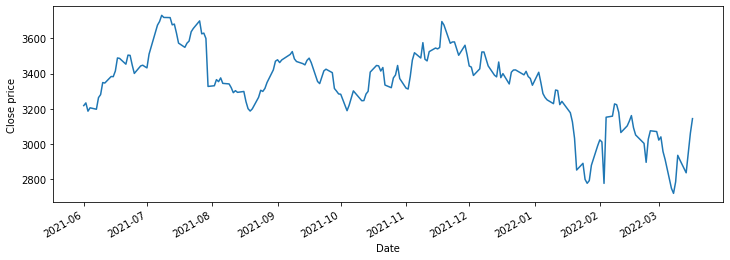

In [131]:
plt.figure(figsize=(12,4))
stock_data['Close'].plot()
#
plt.ylabel("Close price")
plt.show()

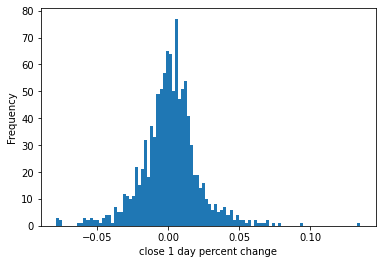

In [64]:
stock_data['Close'].pct_change().plot.hist(bins=100)
plt.xlabel("close 1 day percent change")
plt.show()

가격변동률이 대부분 -0.01~ 0.01 사이의 범위에 속하는 것을 볼 수 있다.


In [65]:
feature_names = [] # 기능이름을 보관

for n in [14, 30, 50]:
    stock_data['sma' + str(n)] = talib.SMA(stock_data['Close'].values, timeperiod=n) # ma(moving average): 이동평균  
    stock_data['rsi' + str(n)] = talib.RSI(stock_data['Close'].values, timeperiod=n)#rsi(relative strength index) : 상대 강도 지수 (주식이 과매수인지 과매도인지 판단하게하는 지수 ) 

    feature_names = feature_names + ['sma' + str(n), 'rsi' + str(n)]
   

In [123]:

stock_data['Volume_1d_change'] = stock_data['Volume'].pct_change() #거래량 변화 퍼센트 컬럼 추가

volume_features = ['Volume_1d_change']
feature_names.extend(volume_features)



(1005, 15)

In [67]:
#목표변수
stock_data['5d_future_close'] = stock_data['Close'].shift(-5) #5일 후 종가
stock_data['5d_close_future_pct'] = stock_data['5d_future_close'].pct_change(5) #5일  후 종가 퍼센트 차이

In [68]:
stock_data.dropna(inplace=True)


X = stock_data[feature_names]
y = stock_data['5d_close_future_pct']
train_size = int(0.80 * y.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [122]:
stock_data.shape

(1005, 15)

In [70]:
'''

target='5d_future_close'
feature=stock_data.drop(columns=[target]).columns
X = stock_data[feature]
y = stock_data[target]

from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

pipe.fit(X_train,y_train)

pipe.score(X_test,y_test)
'''

"\n\ntarget='5d_future_close'\nfeature=stock_data.drop(columns=[target]).columns\nX = stock_data[feature]\ny = stock_data[target]\n\nfrom category_encoders import OneHotEncoder\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.impute import SimpleImputer \nfrom sklearn.pipeline import make_pipeline\n\npipe = make_pipeline(\n    OneHotEncoder(use_cat_names=True), \n    SimpleImputer(), \n    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)\n)\n\npipe.fit(X_train,y_train)\n\npipe.score(X_test,y_test)\n"

n_estimators : 생성할 Tree 개수

max_features : 최대 선택할 특성의 수 



In [71]:
grid = {'n_estimators': [1200],'min_samples_leaf' : [8],'min_samples_split' : [5],'max_features':[4,7], 'max_depth': [1], 'random_state': [42]}
test_scores = []

rf_model = RandomForestRegressor()

for g in ParameterGrid(grid):
    rf_model.set_params(**g) 
    rf_model.fit(X_train, y_train)
    test_scores.append(rf_model.score(X_test, y_test))

best_index = np.argmax(test_scores)
print(test_scores[best_index], ParameterGrid(grid)[best_index])

0.07230331979772275 {'random_state': 42, 'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 4, 'max_depth': 1}


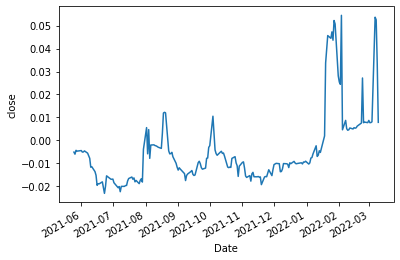

In [72]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=1, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

y_pred_series = pd.Series(y_pred, index=y_test.index)
y_pred_series.plot()
plt.ylabel('close')
plt.show()

In [73]:

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.03138656407254451
Mean Squared Error: 0.0017738356951970782
Root Mean Squared Error: 0.04211692884336509


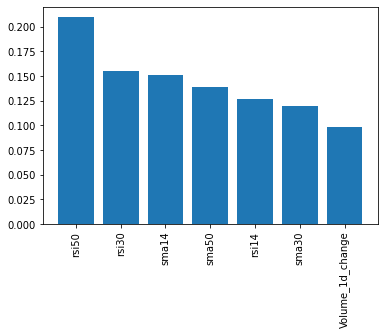

In [118]:
importances = rf_model.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x_values = range(len(importances))
labels = np.array(feature_names)[sorted_index]
plt.bar(x_values, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()

In [75]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

model=ARIMA(y_train,order=(2,1,2))
model_fit = model.fit(trend = 'c', full_output = True, disp = True)



In [76]:
print(model_fit.summary())

                               ARIMA Model Results                               
Dep. Variable:     D.5d_close_future_pct   No. Observations:                  803
Model:                    ARIMA(2, 1, 2)   Log Likelihood                1755.921
Method:                          css-mle   S.D. of innovations              0.027
Date:                   Tue, 22 Mar 2022   AIC                          -3499.841
Time:                           05:26:11   BIC                          -3471.711
Sample:                                1   HQIC                         -3489.037
                                                                                 
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        4.958e-06   1.83e-05      0.270      0.787    -3.1e-05    4.09e-05
ar.L1.D.5d_close_future_pct    -0.2228      0.023     -9

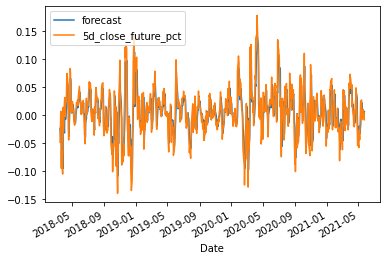

In [77]:
fig=model_fit.plot_predict()

# 단순 회귀 모델로 주가 예측하기

In [78]:
data=yf.download('amzn', start="2018-01-01", end="2022-03-01")
data=data.reset_index(drop=False)

data['time']=data.sort_index(ascending=True).index

train_data=data.loc[data.time<=800][['Close','time']]
print(len(train_data))
test_data=data.loc[data.time>=800][['Close','time']]
print(len(test_data))

[*********************100%***********************]  1 of 1 completed
801
247


In [79]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,time
0,2018-01-02,1172.000000,1190.000000,1170.510010,1189.010010,1189.010010,2694500,0
1,2018-01-03,1188.300049,1205.489990,1188.300049,1204.199951,1204.199951,3108800,1
2,2018-01-04,1205.000000,1215.869995,1204.660034,1209.589966,1209.589966,3022100,2
3,2018-01-05,1217.510010,1229.140015,1210.000000,1229.140015,1229.140015,3544700,3
4,2018-01-08,1236.000000,1253.079956,1232.030029,1246.869995,1246.869995,4279500,4
...,...,...,...,...,...,...,...,...
1042,2022-02-22,3009.570068,3059.649902,2969.709961,3003.949951,3003.949951,3306400,1042
1043,2022-02-23,3033.010010,3035.260010,2893.020020,2896.540039,2896.540039,3212200,1043
1044,2022-02-24,2796.750000,3034.979980,2790.000000,3027.159912,3027.159912,5039300,1044
1045,2022-02-25,3011.000000,3079.800049,2984.270020,3075.770020,3075.770020,3119800,1045


In [80]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

Close_tr=train_data['Close']
time_tr=train_data['time']
time_tr=sm.add_constant(time_tr)
mod=sm.OLS(Close_tr,time_tr)
res=mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     2177.
Date:                Tue, 22 Mar 2022   Prob (F-statistic):          2.36e-230
Time:                        05:26:13   Log-Likelihood:                -5756.2
No. Observations:                 801   AIC:                         1.152e+04
Df Residuals:                     799   BIC:                         1.153e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1191.1533     22.597     52.713      0.0

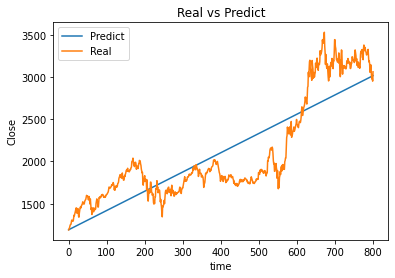

In [81]:
train_result=res.predict(time_tr)
plt.plot(train_data['time'],train_result, label='Predict')
plt.plot(train_data["time"], Close_tr, label = "Real")
plt.xlabel("time")
plt.ylabel("Close")
plt.legend()
plt.title("Real vs Predict")
plt.show()


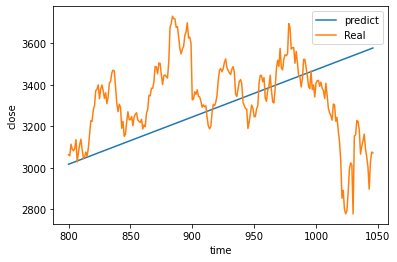

In [82]:
Close_test=test_data['Close']
time_test=test_data['time']
time_test=sm.add_constant(time_test)
test_result=res.predict(time_test)


plt.plot(test_result, label='predict')
plt.plot(Close_test, label='Real')
plt.xlabel('time')
plt.ylabel('close')
plt.legend()
plt.show()

In [127]:
print(model.score(Close_test,_test))

ValueError: ignored

선형 모형이기에 변동성을 반영하기 힘들어 보이지만 간단한 추세는 확인할 수 있지만
실제 값과는 상당히 많이 차이가 난다.


그렇다면 랜덤포레스트 모델로 주가를 예측해보자

랜덤포레스트 모델


In [106]:
df= yf.download('amzn', start="2018-01-01", end="2022-03-01")
df=df.sort_index(ascending=True)
df=df.reset_index()
df['return']=np.nan
df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,return
0,2018-01-02,1172.000000,1190.000000,1170.510010,1189.010010,1189.010010,2694500,NaN
1,2018-01-03,1188.300049,1205.489990,1188.300049,1204.199951,1204.199951,3108800,NaN
2,2018-01-04,1205.000000,1215.869995,1204.660034,1209.589966,1209.589966,3022100,NaN
3,2018-01-05,1217.510010,1229.140015,1210.000000,1229.140015,1229.140015,3544700,NaN
4,2018-01-08,1236.000000,1253.079956,1232.030029,1246.869995,1246.869995,4279500,NaN
...,...,...,...,...,...,...,...,...
1042,2022-02-22,3009.570068,3059.649902,2969.709961,3003.949951,3003.949951,3306400,NaN
1043,2022-02-23,3033.010010,3035.260010,2893.020020,2896.540039,2896.540039,3212200,NaN
1044,2022-02-24,2796.750000,3034.979980,2790.000000,3027.159912,3027.159912,5039300,NaN
1045,2022-02-25,3011.000000,3079.800049,2984.270020,3075.770020,3075.770020,3119800,NaN


주식가격이 전날보다 올랐으면 return 에 1을 넣고 전날보다 떨어졌으면 0을 넣는다

In [107]:
data=df[['Close','return']]

for i in range(len(data)-1):
  if (data.iloc[i+1]["Close"]/data.iloc[i]["Close"])-1 >=0:
    data.iloc[i+1]['return'] = 1
  else:
    data.iloc[i+1]['return'] = 0

print(data.head())
print(data.tail())

         Close  return
0  1189.010010     NaN
1  1204.199951     1.0
2  1209.589966     1.0
3  1229.140015     1.0
4  1246.869995     1.0
            Close  return
1042  3003.949951     0.0
1043  2896.540039     0.0
1044  3027.159912     1.0
1045  3075.770020     1.0
1046  3071.260010     0.0


In [108]:
feature_list=[]
label_list = []

for i in range(len(data)-7):
  feature_list.append(np.array(data.iloc[i:i+7]['Close']))
  label_list.append(np.array(data.iloc[i+7]['return']))

data_X=np.array(feature_list)
data_Y=np.array(label_list)



In [110]:
train_data, train_label = data_X[:-200], data_Y[:-200]
test_data, test_label = data_X[-200:], data_Y[-200:]

train_data= pd.DataFrame(train_data)
train_label= pd.DataFrame(train_label)
test_data= pd.DataFrame(test_data)
test_label= pd.DataFrame(test_label)


train_data #0 close, 1  

,0,1,2,3,4,5,6
0,1189.010010,1204.199951,1209.589966,1229.140015,1246.869995,1252.699951,1254.329956
1,1204.199951,1209.589966,1229.140015,1246.869995,1252.699951,1254.329956,1276.680054
2,1209.589966,1229.140015,1246.869995,1252.699951,1254.329956,1276.680054,1305.199951
3,1229.140015,1246.869995,1252.699951,1254.329956,1276.680054,1305.199951,1304.859985
4,1246.869995,1252.699951,1254.329956,1276.680054,1305.199951,1304.859985,1295.000000
...,...,...,...,...,...,...,...
835,3458.500000,3471.310059,3467.419922,3386.489990,3311.870117,3270.540039,3306.370117
836,3471.310059,3467.419922,3386.489990,3311.870117,3270.540039,3306.370117,3291.610107
837,3467.419922,3386.489990,3311.870117,3270.540039,3306.370117,3291.610107,3190.489990
838,3386.489990,3311.870117,3270.540039,3306.370117,3291.610107,3190.489990,3223.909912


	Open	High	Low	Close	Adj Close	Volume	return
	1172.000000	1190.000000	1170.510010	1189.010010	1189.010010	2694500	NaN

In [87]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()
model.fit(train_data,train_label)
y_pred=model.predict(test_data) 
print('accuracy:',metrics.accuracy_score(y_pred,test_label))

accuracy: 0.525


In [95]:
from sklearn.model_selection import cross_val_score, GridSearchCV

dists = [{"n_estimators" : [2,4,6,8,10],
          "criterion" : ["gini","entropy"],
          "min_samples_leaf":[2,4,6,8,10],
          "random_state":[1]}]

forest_grid=GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=dists,
    scoring='accuracy',
    cv=10,
    n_jobs=-1
)

forest_grid_result=forest_grid.fit(train_data,train_label)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f70bafc4550>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f70bb023a90>})

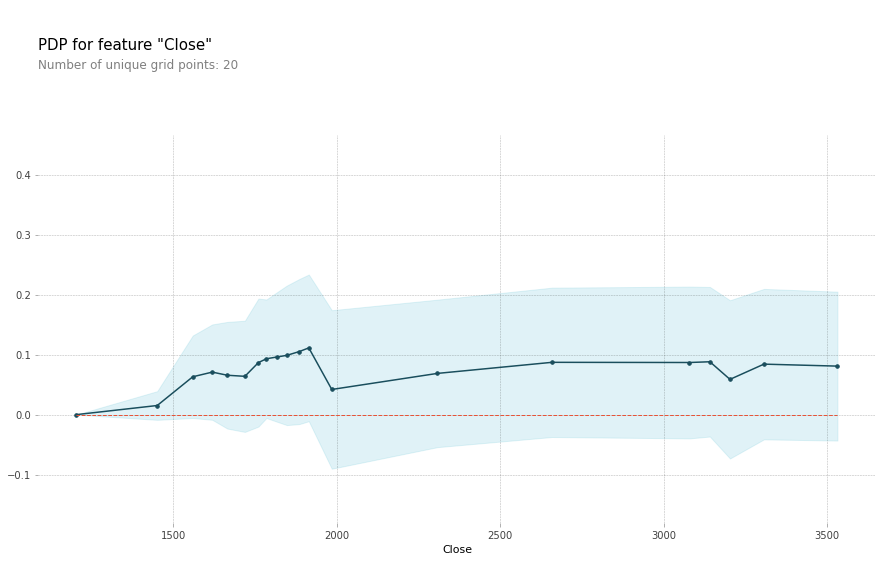

In [116]:
from sklearn.linear_model import LinearRegression
from category_encoders import TargetEncoder


random = make_pipeline(
    TargetEncoder(),  
    RandomForestClassifier()
)

random.fit(train_data,train_label)
isolated = pdp_isolate(
    model=model, 
    dataset=train_data, 
    model_features=train_data.columns, 
    feature=1,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=20 # default=10
)
pdp_plot(isolated, feature_name='Close')

In [ ]:
best_forest_paramters=forest_grid_result.best_params_
forset_score=forest_grid_result.best_score_

print(forest_grid_result.best_params_)

In [ ]:
model=RandomForestClassifier(
    n_estimators=10,
    min_samples_leaf=6,
    criterion=best_forest_paramters['criterion'],
    random_state=1
)
model.fit(train_data,train_label)
y_pred=model.predict(test_data)

print('accuracy:',metrics.accuracy_score(y_pred,test_label))

로지스틱 회귀 모델 만들기


In [ ]:
logi_df= yf.download('amzn', start="2018-01-01", end="2022-03-01")

In [ ]:
logi_df['S_10'] = logi_df['Close'].rolling(window=10).mean()
logi_df['Corr']=logi_df['Close'].rolling(window=10).corr(logi_df['S_10'])
logi_df['Rsi']=talib.RSI(np.array(logi_df['Close']))
logi_df['Open-Close']= logi_df['Open']-logi_df['Close'].shift(1)
logi_df['Open-Open']=logi_df['Open']-logi_df['Open'].shift(1)
logi_df=logi_df.dropna()
X=0
X=logi_df.iloc[:,:9]

In [ ]:
y=0
y=np.where(logi_df['Close'].shift(-1)> logi_df['Close'],1,-1)

In [ ]:
split = int(0.7*len(df))
X_train_logi, X_test_logi, y_train_logi, y_test_logi = X[:split], X[split:], y[:split], y[split:]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

model=0
model = LogisticRegression()
model = model.fit (X_train_logi,y_train_logi)

In [ ]:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_))) #coef : 회귀 계수 , 

설명변수 평가 :

Pr( > | t | )열은 t분포를 사용하여 각 변수가 얼마나 유의한지를 판단할 수 있는 p-value값을 의미.
0.05보다 낮으면 회귀계수 또는 절편이 0이라는 귀무가설을 기각하고 회귀계수 또는 절편이 0이 아니라는 대립가설을 채택한다

In [ ]:
probability = model.predict_proba(X_test_logi)
predicted=model.predict(X_test_logi)

In [ ]:
print(metrics.confusion_matrix(y_test_logi, predicted))

In [ ]:
cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())

https://blog.quantinsti.com/machine-learning-logistic-regression-python/

In [ ]:
logi_df['Predicted_Signal'] = model.predict(X)
logi_df['Nifty_returns'] = np.log(logi_df['Close']/logi_df['Close'].shift(1))
Cumulative_Nifty_returns = np.cumsum(logi_df[split:]['Nifty_returns'])

logi_df['Startegy_returns'] = logi_df['Nifty_returns']* logi_df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(logi_df[split:]['Startegy_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_Nifty_returns, color='r',label = 'Nifty Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

In [94]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.linear_model import LinearRegression
from category_encoders import TargetEncoder
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
feature='Close'

linear = make_pipeline(
    TargetEncoder(),  
    LinearRegression()
)

linear.fit(X_train_logi,y_train_logi)
isolated = pdp_isolate(
    model=model, 
    dataset=X_train_logi, 
    model_features=X_train_logi.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

ValueError: ignored